# SAS Viya Dimension Reduction

"The curse of dimensionality refers to various phenomena that arise when analyzing and organizing data in high-dimensional spaces that do not occur in low-dimensional settings such as the three-dimensional physical space of everyday experience. The expression was coined by Richard E. Bellman when considering problems in dynamic programming. Dimensionally cursed phenomena occur in domains such as numerical analysis, sampling, combinatorics, machine learning, data mining and databases. **The common theme of these problems is that when the dimensionality increases, the volume of the space increases so fast that the available data become sparse. In order to obtain a reliable result, the amount of data needed often grows exponentially with the dimensionality.** Also, organizing and searching data often relies on detecting areas where objects form groups with similar properties; in high dimensional data, however, all objects appear to be sparse and dissimilar in many ways, which prevents common data organization strategies from being efficient." - Wikipedia

![title](intro_vs.PNG)

# Data

| Name      | Model Role | Measurement Level | Description                                                            |
|:----------|:-----------|:------------------|:-----------------------------------------------------------------------|
| BAD       | Target     | Binary            | 1 = applicant defaulted on loan or delinquent, 0 = applicant paid loan |
| CLAGE     | Input      | Interval          | Age of oldest credit line in months                                    |
| CLNO      | Input      | Interval          | Number of credit lines                                                 |
| DEBTINC   | Input      | Interval          | Debt-to-income ratio                                                   |
| DELINQ    | Input      | Interval          | Number of delinquent credit lines                                      |
| DEROG     | Input      | Interval          | Number of derogatory reports                                           |
| JOB       | Input      | Nominal           | Occupational categories                                                |
| LOAN      | Input      | Interval          | Amount of loan request                                                 |
| MORTDUE   | Input      | Interval          | Amount due on existing mortgage                                        |
| NINQ      | Input      | Interval          | Number of recent credit inquiries                                      |
| REASON    | Input      | Binary            | DebtCon = debt consolidation, HomeImp = home improvement               |
| VALUE     | Input      | Interval          | Value of current property                                              |
| YOJ       | Input      | Interval          | Years at present job                                                   |

# Load Packages

In [1]:
import swat
swat.options.cas.print_messages = False
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import os

# Get Key Variables

In [2]:
os.chdir("/".join(os.getcwd().split("\\")[:-1]))
from password_sse import hostname, access_token_file, pem_file, wd

# Connect to CAS

In [3]:
access_token = open(access_token_file, "r").read()
conn = swat.CAS(hostname=hostname, password=access_token, ssl_ca_list=pem_file)

# Load Action Sets

In [4]:
action_sets = ['simple','sampling','dataStep','varReduce','gVarCluster','pca','robustPca','regression','decisionTree','deepLearn','autotune']
for action_set in action_sets:
    conn.loadActionSet(action_set)

# Load Data

In [5]:
df_cas = conn.read_csv(wd+"Data/"+"hmeq.csv", casout=dict(name="hmeq", replace=True))
conn.tableInfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,View,MultiPart,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime,TableRedistUpPolicy
0,HMEQ,5960,13,0,utf-8,2024-08-14T17:22:33+00:00,2024-08-14T17:22:33+00:00,2024-08-14T17:22:33+00:00,UTF8,2.039275e+09,0,0,,,0,Jordan.Bakerman@sas.com,,2024-08-14T17:22:33+00:00,2.039275e+09,Not Specified


# View Data

In [6]:
df_cas.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1.0,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1.0,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1.0,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1.0,1500.0,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [7]:
df_cas.shape

(5960, 13)

In [8]:
df_cas.mean()

BAD             0.199497
LOAN        18607.969799
MORTDUE     73760.817200
VALUE      101776.048741
YOJ             8.922268
DEROG           0.254570
DELINQ          0.449442
CLAGE         179.766275
NINQ            1.186055
CLNO           21.296096
DEBTINC        33.779915
dtype: float64

In [9]:
df_cas.describe(include=['numeric', 'character'])

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5708.0,5681.0,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
unique,2.000000,540.000000,5053.000000,5381.000000,2.0,6.0,99.000000,11.000000,14.000000,5314.000000,16.000000,62.000000,4693.000000
top,0.000000,15000.000000,42000.000000,60000.000000,NaN,NaN,0.000000,0.000000,0.000000,206.966667,0.000000,16.000000,203.312149
freq,4771.000000,105.000000,11.000000,15.000000,3928.0,2388.0,415.000000,4527.000000,4179.000000,7.000000,2531.000000,316.000000,1.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,NaN,NaN,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,NaN,NaN,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46268.000000,66069.000000,NaN,NaN,3.000000,0.000000,0.000000,115.103197,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,NaN,NaN,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91491.000000,119831.500000,NaN,NaN,13.000000,0.000000,0.000000,231.574834,2.000000,26.000000,39.003141


In [10]:
conn.simple.correlation(
    table = "hmeq",
    inputs = ["CLAGE","CLNO","DEBTINC","DELINQ","DEROG","LOAN","MORTDUE","NINQ","VALUE","YOJ"]
)["Correlation"]

,Variable,CLAGE,CLNO,DEBTINC,DELINQ,DEROG,LOAN,MORTDUE,NINQ,VALUE,Nobs1,Nobs2,Nobs3,Nobs4,Nobs5,Nobs6,Nobs7,Nobs8,Nobs9,Nobs10
0,CLAGE,1.000000,0.237987,-0.046477,0.022488,-0.083047,0.088540,0.140047,-0.116935,0.171238,5652.0,5652.0,4466.0,5294.0,5166.0,5652.0,5239.0,5364.0,5559.0,5271.0
1,CLNO,0.237987,1.000000,0.185539,0.164639,0.061884,0.072631,0.323631,0.088389,0.269149,5652.0,5738.0,4529.0,5380.0,5252.0,5738.0,5301.0,5450.0,5644.0,5340.0
2,DEBTINC,-0.046477,0.185539,1.000000,0.052364,0.017065,0.084735,0.154939,0.141344,0.132174,4466.0,4529.0,4693.0,4217.0,4115.0,4693.0,4291.0,4277.0,4662.0,4264.0
3,DELINQ,0.022488,0.164639,0.052364,1.000000,0.211832,-0.035144,-0.001044,0.067812,-0.014103,5294.0,5380.0,4217.0,5380.0,5175.0,5380.0,5041.0,5297.0,5292.0,5059.0
4,DEROG,-0.083047,0.061884,0.017065,0.211832,1.000000,-0.001302,-0.049516,0.173934,-0.048689,5166.0,5252.0,4115.0,5175.0,5252.0,5252.0,4895.0,5144.0,5168.0,4914.0
5,LOAN,0.088540,0.072631,0.084735,-0.035144,-0.001302,1.000000,0.228595,0.044487,0.335393,5652.0,5738.0,4693.0,5380.0,5252.0,5960.0,5442.0,5450.0,5848.0,5445.0
6,MORTDUE,0.140047,0.323631,0.154939,-0.001044,-0.049516,0.228595,1.000000,0.031392,0.875666,5239.0,5301.0,4291.0,5041.0,4895.0,5442.0,5442.0,5094.0,5357.0,5123.0
7,NINQ,-0.116935,0.088389,0.141344,0.067812,0.173934,0.044487,0.031392,1.000000,-0.004398,5364.0,5450.0,4277.0,5297.0,5144.0,5450.0,5094.0,5450.0,5357.0,5127.0
8,VALUE,0.171238,0.269149,0.132174,-0.014103,-0.048689,0.335393,0.875666,-0.004398,1.000000,5559.0,5644.0,4662.0,5292.0,5168.0,5848.0,5357.0,5357.0,5848.0,5345.0
9,YOJ,0.201718,0.024838,-0.055891,0.038153,-0.065879,0.105728,-0.088480,-0.071627,0.007759,5271.0,5340.0,4264.0,5059.0,4914.0,5445.0,5123.0,5127.0,5345.0,5445.0


In [11]:
conn.simple.distinct(
    table = "hmeq",
    inputs = ["BAD","JOB","REASON"]
)

,Column,NDistinct,NMiss,Trunc
0,BAD,2.0,0.0,0.0
1,JOB,7.0,279.0,0.0
2,REASON,3.0,252.0,0.0


In [12]:
conn.simple.freq(
    table = "hmeq",
    inputs = ["BAD","JOB","REASON"]
)

,Column,NumVar,CharVar,FmtVar,Level,Frequency
0,BAD,0.0,,0,1,4771.0
1,BAD,1.0,,1,2,1189.0
2,JOB,NaN,,,1,279.0
3,JOB,NaN,Mgr,Mgr,2,767.0
4,JOB,NaN,Office,Office,3,948.0
5,JOB,NaN,Other,Other,4,2388.0
6,JOB,NaN,ProfExe,ProfExe,5,1276.0
7,JOB,NaN,Sales,Sales,6,109.0
8,JOB,NaN,Self,Self,7,193.0
9,REASON,NaN,,,1,252.0


# Plot Data Locally

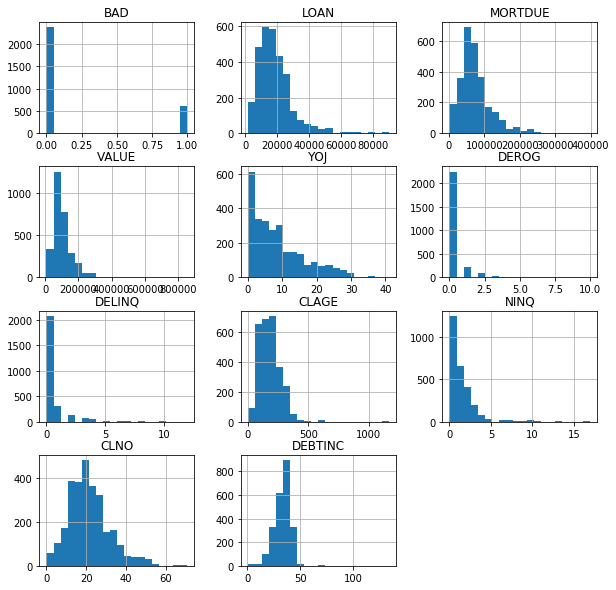

In [13]:
conn.sampling.srs(
    table   = "hmeq",
    samppct = 50,
    seed = 12345,
    partind = False,
    output  = dict(casOut = dict(name = 'mysam', replace = True),  copyVars = 'ALL')
)

mysam = conn.CASTable(name = "mysam")
df = mysam.to_frame()
df.hist(bins=20, figsize=(10,10))
plt.show()

# Impute Missing

In [14]:
tbl = df_cas.distinct()['Distinct'][['Column', 'NMiss']]
nr = df_cas.shape[0]
tbl['PctMiss'] = tbl['NMiss']/nr
tbl

,Column,NMiss,PctMiss
0,BAD,0.0,0.000000
1,LOAN,0.0,0.000000
2,MORTDUE,518.0,0.086913
3,VALUE,112.0,0.018792
4,REASON,252.0,0.042282
5,JOB,279.0,0.046812
6,YOJ,515.0,0.086409
7,DEROG,708.0,0.118792
8,DELINQ,580.0,0.097315
9,CLAGE,308.0,0.051678


In [15]:
conn.dataPreprocess.impute(
    table = "hmeq",
    methodContinuous = 'median',
    methodNominal    = 'mode',
    inputs           = list(df_cas)[1:],
    copyAllVars      = True,
    casOut           = dict(name = "hmeq", replace = True)
)

,Variable,ImputeTech,ResultVar,N,NMiss,ImputedValueContinuous,ImputedValueNominal
0,LOAN,Median,IMP_LOAN,5960.0,0.0,16300.000000,
1,MORTDUE,Median,IMP_MORTDUE,5442.0,518.0,65019.000000,
2,VALUE,Median,IMP_VALUE,5848.0,112.0,89235.500000,
3,REASON,Mode,IMP_REASON,5708.0,252.0,NaN,DebtCon
4,JOB,Mode,IMP_JOB,5681.0,279.0,NaN,Other
5,YOJ,Median,IMP_YOJ,5445.0,515.0,7.000000,
6,DEROG,Median,IMP_DEROG,5252.0,708.0,0.000000,
7,DELINQ,Median,IMP_DELINQ,5380.0,580.0,0.000000,
8,CLAGE,Median,IMP_CLAGE,5652.0,308.0,173.466667,
9,NINQ,Median,IMP_NINQ,5450.0,510.0,1.000000,


# Partition Data

In [16]:
conn.sampling.srs(
    table   = "hmeq",
    samppct = 70,
    seed = 919,
    partind = True,
    output  = dict(casOut = dict(name = "hmeq", replace = True),  copyVars = 'ALL')
)

print("Train Obs", sum(df_cas["_PartInd_"]==1))
print("Test Obs", sum(df_cas["_PartInd_"]==0))
print("Total Obs", df_cas.shape[0])

Train Obs 4172.0
Test Obs 1788.0
Total Obs 5960


# Get Variables

In [17]:
colinfo = conn.table.columninfo(table="hmeq")['ColumnInfo']
display(colinfo)

target = colinfo['Column'][0]

inputs = list(colinfo['Column'][1:])
nominals = list(colinfo.query('Type=="varchar"')['Column'])

inputs = [k for k in inputs if 'IMP_' in k]
nominals = [k for k in nominals if 'IMP_' in k]
nominals = [target] + nominals

print(target)
print(inputs)
print(nominals)

,Column,Label,ID,Type,RawLength,FormattedLength,Format,NFL,NFD
0,BAD,,1,double,8,12,,0,0
1,LOAN,,2,double,8,12,,0,0
2,MORTDUE,,3,double,8,12,,0,0
3,VALUE,,4,double,8,12,,0,0
4,REASON,,5,varchar,7,7,,0,0
5,JOB,,6,varchar,7,7,,0,0
6,YOJ,,7,double,8,12,,0,0
7,DEROG,,8,double,8,12,,0,0
8,DELINQ,,9,double,8,12,,0,0
9,CLAGE,,10,double,8,12,,0,0


BAD
['IMP_CLAGE', 'IMP_CLNO', 'IMP_DEBTINC', 'IMP_DELINQ', 'IMP_DEROG', 'IMP_LOAN', 'IMP_MORTDUE', 'IMP_NINQ', 'IMP_VALUE', 'IMP_YOJ', 'IMP_JOB', 'IMP_REASON']
['BAD', 'IMP_JOB', 'IMP_REASON']


![title](reg_based_vs.PNG)

# Feature Selection - Regression

### Forward

In [18]:
forward = conn.regression.logistic(
    table    = dict(name = "hmeq", where = '_PartInd_ = 1'),
    classVars = nominals[1:],
    model = dict(depvar=target, effects=inputs, dist='binomial', link='logit'),
    selection=dict(method='forward', select="sl", slentry=0.01),
    store    = dict(name='lr_forward_model',replace=True)
)

Forward_inputs = forward["Summary.SelectedEffects"]["Effects"][0].split()
Forward_inputs.remove("Intercept")
Forward_inputs

['IMP_CLAGE',
 'IMP_DEBTINC',
 'IMP_DELINQ',
 'IMP_DEROG',
 'IMP_LOAN',
 'IMP_NINQ',
 'IMP_JOB',
 'IMP_REASON']

### Backward

In [19]:
backward = conn.regression.logistic(
    table    = dict(name = "hmeq", where = '_PartInd_ = 1'),
    classVars = nominals[1:],
    model = dict(depvar=target, effects=inputs, dist='binomial', link='logit'),
    selection=dict(method='backward', select="sl", slstay=0.01),
    store    = dict(name='lr_backward_model',replace=True)
)

Backward_inputs = backward["Summary.SelectedEffects"]["Effects"][0].split()
Backward_inputs.remove("Intercept")
Backward_inputs

['IMP_CLAGE',
 'IMP_DEBTINC',
 'IMP_DELINQ',
 'IMP_DEROG',
 'IMP_LOAN',
 'IMP_MORTDUE',
 'IMP_NINQ',
 'IMP_VALUE',
 'IMP_JOB',
 'IMP_REASON']

### Stepwise

In [20]:
stepwise = conn.regression.logistic(
    table    = dict(name = "hmeq", where = '_PartInd_ = 1'),
    classVars = nominals[1:],
    model = dict(depvar=target, effects=inputs, dist='binomial', link='logit'),
    selection=dict(method='stepwise', select="sl", slentry=0.01, slstay=0.01),
    store    = dict(name='lr_stepwise_model',replace=True)
)

Stepwise_inputs = stepwise["Summary.SelectedEffects"]["Effects"][0].split()
Stepwise_inputs.remove("Intercept")
Stepwise_inputs

['IMP_CLAGE',
 'IMP_DEBTINC',
 'IMP_DELINQ',
 'IMP_DEROG',
 'IMP_LOAN',
 'IMP_NINQ',
 'IMP_JOB',
 'IMP_REASON']

### LASSO

In [21]:
lasso = conn.regression.logistic(
    table    = dict(name = "hmeq", where = '_PartInd_ = 1'),
    classVars = nominals[1:],
    model = dict(depvar=target, effects=inputs, dist='binomial', link='logit', centerlasso=True),
    selection=dict(method='lasso', choose="aic"),
    store    = dict(name='lr_lasso_model',replace=True)
)

Lasso_inputs = lasso["SelectionSummary.SelectedEffects"]["Effects"][0].split()
Lasso_inputs.remove("Intercept")
Lasso_inputs

['IMP_CLAGE',
 'IMP_CLNO',
 'IMP_DEBTINC',
 'IMP_DELINQ',
 'IMP_DEROG',
 'IMP_LOAN',
 'IMP_MORTDUE',
 'IMP_NINQ',
 'IMP_VALUE',
 'IMP_YOJ',
 'IMP_JOB',
 'IMP_REASON']

# Model Building, Scoring, and Assessment Functionality

In [22]:
def model_func(features):
    tmp_dict = dict(
        table    = dict(name = "hmeq", where = '_PartInd_ = 1'),
        target = target,
        inputs = eval(features+"_inputs"),
        nominals = [target]+list(set(nominals) & set(eval(features+"_inputs"))),
        seed = 802,
        casout = dict(name=features+'_model', replace=True)
    )
    return tmp_dict

def score_func(model):
    tmp_dict = dict(
        table    = dict(name = "hmeq", where = '_PartInd_ = 0'),
        model = model+'_model',
        casout = dict(name=model+'_scored', replace=True),
        copyVars = target,
        encodename = True,
        assessonerow = True
    )
    return tmp_dict

def assess_func(model):
    tmp_dict = dict(
        table = model+'_scored',
        inputs = 'P_'+target+'1',
        casout = dict(name=model+'_assess' ,replace=True),
        response = target,
        event = "1"
    )
    return tmp_dict

def assess_local(model):
    castbl_obj = conn.CASTable(name = model+'_assess_ROC')
    local_tbl = castbl_obj.to_frame()
    local_tbl['Model'] = "GB and " + model + " Selection"
    return local_tbl

### Model Comparison

In [23]:
selected_inputs = ['Forward','Backward','Stepwise','Lasso']
model_action = 'conn.decisionTree.gbtreeTrain'
score_action = 'conn.decisionTree.gbtreeScore'
assess_action = 'conn.percentile.assess'

for i in list(range(len(selected_inputs))):
    
    model_params = model_func(selected_inputs[i])
    model_str = model_action+'(**model_params)'
    model_obj = eval(model_str)
    
    score_params = score_func(selected_inputs[i])
    score_str = score_action+'(**score_params)'
    score = eval(score_str)
    
    assess_params = assess_func(selected_inputs[i])
    assess_str = assess_action+'(**assess_params)'
    assess_obj = eval(assess_str)
    
df_assess = pd.DataFrame()
for i in list(range(len(selected_inputs))):
    df_assess = pd.concat([df_assess, assess_local(selected_inputs[i])])
    
cutoff_index = round(df_assess['_Cutoff_'],2)==0.5
compare = df_assess[cutoff_index].reset_index(drop=True)
compare['Misclassification'] = 1-compare['_ACC_']
all_models_reg_inputs = pd.DataFrame(compare[round(compare['_Cutoff_'],2)==0.5][['Model','Misclassification','_C_']])
all_models_reg_inputs = all_models_reg_inputs.rename(columns={'_C_': 'Area Under ROC Curve'})
all_models_reg_inputs["N Variables"] = [len(Forward_inputs),len(Backward_inputs),len(Stepwise_inputs),len(Lasso_inputs)]
all_models_reg_inputs.sort_values('Misclassification')

,Model,Misclassification,Area Under ROC Curve,N Variables
3,GB and Lasso Selection,0.106264,0.923188,12
1,GB and Backward Selection,0.112416,0.915309,10
0,GB and Forward Selection,0.114094,0.903342,8
2,GB and Stepwise Selection,0.114094,0.903342,8


![title](tree_based_vs.PNG)

# Feature Selection - Trees

### Decision Tree

In [24]:
dt = conn.decisionTree.dtreeTrain( 
    table = dict(name = "hmeq", where = '_PartInd_ = 1'), 
    target = target, 
    inputs = inputs, 
    nominals = nominals,
    varImp = True,
    casOut = dict(name = 'dt_model', replace = True) 
)

dt_imp = pd.DataFrame(dt['DTreeVarImpInfo'])
display(dt_imp)

Decision_Tree_inputs = list(dt_imp[dt_imp['Importance'] > 10]['Variable'])
Decision_Tree_inputs

,Variable,Importance,Std,Count
0,IMP_DELINQ,106.624635,NaN,2.0
1,IMP_DEBTINC,78.291738,NaN,3.0
2,IMP_DEROG,42.649733,NaN,1.0
3,IMP_LOAN,24.073376,NaN,2.0
4,IMP_CLNO,15.611814,NaN,3.0
5,IMP_CLAGE,14.897427,NaN,3.0
6,IMP_MORTDUE,11.680556,NaN,1.0
7,IMP_VALUE,6.239127,NaN,1.0
8,IMP_REASON,2.146032,NaN,1.0
9,IMP_YOJ,1.050000,NaN,1.0


['IMP_DELINQ',
 'IMP_DEBTINC',
 'IMP_DEROG',
 'IMP_LOAN',
 'IMP_CLNO',
 'IMP_CLAGE',
 'IMP_MORTDUE']

### Random Forest

In [25]:
rf = conn.decisionTree.forestTrain(
    table    = dict(name = "hmeq", where = '_PartInd_ = 1'),
    target   = target, 
    inputs   = inputs, 
    nominals = nominals,
    nTree    = 100,
    m        = 5,
    bootstrap = 0.75,
    varImp   = True,
    seed = 802,
    casOut   = dict(name = 'rf_model', replace = True)
)

rf_imp = pd.DataFrame(rf['DTreeVarImpInfo'])
display(rf_imp)

Random_Forest_inputs = list(rf_imp[rf_imp['Importance'] > 10]['Variable'])
Random_Forest_inputs

,Variable,Importance,Std,Count
0,IMP_DEBTINC,71.238810,56.887531,302.0
1,IMP_DELINQ,68.983180,28.591871,197.0
2,IMP_DEROG,40.549850,21.292215,138.0
3,IMP_LOAN,17.995720,13.612523,160.0
4,IMP_CLAGE,11.593248,9.514482,190.0
5,IMP_CLNO,10.565384,9.280199,170.0
6,IMP_MORTDUE,7.254810,7.947547,137.0
7,IMP_NINQ,4.753625,8.187906,76.0
8,IMP_VALUE,4.295966,5.260320,97.0
9,IMP_JOB,3.323320,4.182860,92.0


['IMP_DEBTINC', 'IMP_DELINQ', 'IMP_DEROG', 'IMP_LOAN', 'IMP_CLAGE', 'IMP_CLNO']

### Gradient Boosting

In [26]:
gb = conn.decisionTree.gbtreeTrain(
    table    = dict(name = "hmeq", where = '_PartInd_ = 1'),
    target   = target, 
    inputs   = inputs, 
    nominals = nominals,
    nTree    = 100,
    m        = 5,
    varImp   = True,
    seed = 802,
    casOut   = dict(name = 'gb_model', replace = True)
)

gb_imp = pd.DataFrame(gb['DTreeVarImpInfo'])
display(gb_imp)

Gradient_Boosting_inputs = list(gb_imp[gb_imp['Importance'] > 2]['Variable'])
Gradient_Boosting_inputs

,Variable,Importance,Std,Count
0,IMP_DEBTINC,16.097644,37.250178,201.0
1,IMP_DELINQ,4.951378,10.318702,78.0
2,IMP_CLAGE,3.999617,5.344677,140.0
3,IMP_DEROG,2.895505,7.936864,47.0
4,IMP_LOAN,2.894277,3.734629,135.0
5,IMP_CLNO,2.629823,2.372949,146.0
6,IMP_VALUE,2.580408,3.223281,132.0
7,IMP_MORTDUE,2.227630,2.201922,120.0
8,IMP_JOB,1.805097,2.100502,97.0
9,IMP_YOJ,1.770234,2.105930,102.0


['IMP_DEBTINC',
 'IMP_DELINQ',
 'IMP_CLAGE',
 'IMP_DEROG',
 'IMP_LOAN',
 'IMP_CLNO',
 'IMP_VALUE',
 'IMP_MORTDUE']

### Model Comparison

In [27]:
selected_inputs = ['Decision_Tree','Random_Forest','Gradient_Boosting']
model_action = 'conn.decisionTree.gbtreeTrain'
score_action = 'conn.decisionTree.gbtreeScore'
assess_action = 'conn.percentile.assess'

for i in list(range(len(selected_inputs))):
    
    model_params = model_func(selected_inputs[i])
    model_str = model_action+'(**model_params)'
    model_obj = eval(model_str)
    
    score_params = score_func(selected_inputs[i])
    score_str = score_action+'(**score_params)'
    score = eval(score_str)
    
    assess_params = assess_func(selected_inputs[i])
    assess_str = assess_action+'(**assess_params)'
    assess_obj = eval(assess_str)
    
df_assess = pd.DataFrame()
for i in list(range(len(selected_inputs))):
    df_assess = pd.concat([df_assess, assess_local(selected_inputs[i])])
    
cutoff_index = round(df_assess['_Cutoff_'],2)==0.5
compare = df_assess[cutoff_index].reset_index(drop=True)
compare['Misclassification'] = 1-compare['_ACC_']
all_models_tree_inputs = pd.DataFrame(compare[round(compare['_Cutoff_'],2)==0.5][['Model','Misclassification','_C_']])
all_models_tree_inputs = all_models_tree_inputs.rename(columns={'_C_': 'Area Under ROC Curve'})
all_models_tree_inputs["N Variables"] = [len(Decision_Tree_inputs),len(Random_Forest_inputs),len(Gradient_Boosting_inputs)]
all_models_tree_inputs.sort_values('Misclassification')

,Model,Misclassification,Area Under ROC Curve,N Variables
1,GB and Random_Forest Selection,0.112416,0.902173,6
2,GB and Gradient_Boosting Selection,0.115213,0.912076,8
0,GB and Decision_Tree Selection,0.118009,0.907340,7


![title](fast_based_vs.PNG)

# Feature Selection - Other

### Fast Supervised

In [28]:
vr_sup = conn.varReduce.super( 
    table = dict(name = "hmeq", where = '_PartInd_ = 1'),
    target = target, 
    inputs = inputs, 
    nominals = nominals, 
    varexp = 0.90 
)

Fast_Supervised_inputs = list(vr_sup['SelectedEffects']['Variable'])
Fast_Supervised_inputs

['IMP_DELINQ',
 'IMP_DEROG',
 'IMP_CLAGE',
 'IMP_DEBTINC',
 'IMP_NINQ',
 'IMP_LOAN',
 'IMP_JOB',
 'IMP_REASON',
 'IMP_CLNO',
 'IMP_MORTDUE',
 'IMP_VALUE',
 'IMP_YOJ']

### Fast Unsupervised

In [29]:
vr_unsup = conn.varReduce.unsuper( 
    table = dict(name = "hmeq", where = '_PartInd_ = 1'),
    inputs = inputs, 
    nominals = nominals[1:], 
    varexp = 0.90 
)

Fast_Unsupervised_inputs = list(vr_unsup['SelectedEffects']['Variable'])
Fast_Unsupervised_inputs

['IMP_REASON',
 'IMP_VALUE',
 'IMP_JOB',
 'IMP_CLAGE',
 'IMP_DELINQ',
 'IMP_DEBTINC',
 'IMP_DEROG',
 'IMP_YOJ',
 'IMP_NINQ',
 'IMP_LOAN']

### Combination

In [30]:
combo_set = \
set(Forward_inputs) & set(Backward_inputs) & set(Stepwise_inputs) & set(Lasso_inputs) & \
set(Decision_Tree_inputs) & set(Random_Forest_inputs) & set(Gradient_Boosting_inputs) & \
set(Fast_Supervised_inputs) & set(Fast_Unsupervised_inputs)
Combination_All_inputs = list(combo_set)
Combination_All_inputs

['IMP_DEBTINC', 'IMP_LOAN', 'IMP_CLAGE', 'IMP_DEROG', 'IMP_DELINQ']

### Model Comparison

In [31]:
selected_inputs = ['Fast_Supervised','Fast_Unsupervised','Combination_All']
model_action = 'conn.decisionTree.gbtreeTrain'
score_action = 'conn.decisionTree.gbtreeScore'
assess_action = 'conn.percentile.assess'

for i in list(range(len(selected_inputs))):
    
    model_params = model_func(selected_inputs[i])
    model_str = model_action+'(**model_params)'
    model_obj = eval(model_str)
    
    score_params = score_func(selected_inputs[i])
    score_str = score_action+'(**score_params)'
    score = eval(score_str)
    
    assess_params = assess_func(selected_inputs[i])
    assess_str = assess_action+'(**assess_params)'
    assess_obj = eval(assess_str)
    
df_assess = pd.DataFrame()
for i in list(range(len(selected_inputs))):
    df_assess = pd.concat([df_assess, assess_local(selected_inputs[i])])
    
cutoff_index = round(df_assess['_Cutoff_'],2)==0.5
compare = df_assess[cutoff_index].reset_index(drop=True)
compare['Misclassification'] = 1-compare['_ACC_']
all_models_other_inputs = pd.DataFrame(compare[round(compare['_Cutoff_'],2)==0.5][['Model','Misclassification','_C_']])
all_models_other_inputs = all_models_other_inputs.rename(columns={'_C_': 'Area Under ROC Curve'})
all_models_other_inputs["N Variables"] = [len(Fast_Supervised_inputs),len(Fast_Unsupervised_inputs),len(Combination_All_inputs)]
all_models_other_inputs.sort_values('Misclassification')

,Model,Misclassification,Area Under ROC Curve,N Variables
0,GB and Fast_Supervised Selection,0.104586,0.923693,12
1,GB and Fast_Unsupervised Selection,0.112416,0.916952,10
2,GB and Combination_All Selection,0.119687,0.896044,5


![title](extract_based_vs.PNG)

# Feature Extraction

### PCA

In [32]:
pca = conn.pca.eig(
    table = "hmeq",
    inputs = ['IMP_CLAGE', 'IMP_CLNO', 'IMP_DEBTINC', 'IMP_DELINQ', 'IMP_DEROG', 'IMP_LOAN', 'IMP_MORTDUE', 'IMP_NINQ', 'IMP_VALUE', 'IMP_YOJ'],
    output  = dict(casOut = dict(name = 'hmeq', replace = True), copyVars=list(df_cas))
)

pca = conn.pca.eig(
    table = "hmeq",
    inputs = ['IMP_CLAGE', 'IMP_CLNO', 'IMP_DEBTINC', 'IMP_DELINQ', 'IMP_DEROG', 'IMP_LOAN', 'IMP_MORTDUE', 'IMP_NINQ', 'IMP_VALUE', 'IMP_YOJ'],
    output  = dict(casOut = dict(name = 'pca', replace = True), copyVars=[target,"_PartInd_"])
)

display(pca['Eigenvalues'])

pca_cutoff = 0.8
pca_num = [x for x,i in enumerate(pca['Eigenvalues']['Cumulative']) if i>pca_cutoff ][0]+1
PCA_inputs = ["Score"+str(x) for x in range(1,pca_num+1)]
PCA_inputs

,Number,Eigenvalue,Difference,Proportion,Cumulative
0,1,2.224361,0.827963,0.222436,0.222436
1,2,1.396398,0.154516,0.139640,0.362076
2,3,1.241882,0.240047,0.124188,0.486264
3,4,1.001835,0.041798,0.100183,0.586448
4,5,0.960036,0.111889,0.096004,0.682451
5,6,0.848147,0.063924,0.084815,0.767266
6,7,0.784222,0.065585,0.078422,0.845688
7,8,0.718638,0.089445,0.071864,0.917552
8,9,0.629192,0.433904,0.062919,0.980471
9,10,0.195288,NaN,0.019529,1.000000


['Score1', 'Score2', 'Score3', 'Score4', 'Score5', 'Score6', 'Score7']

### SVD

In [33]:
svd = conn.robustPca.robustpca(
    table = "hmeq",
    inputs = ['IMP_CLAGE', 'IMP_CLNO', 'IMP_DEBTINC', 'IMP_DELINQ', 'IMP_DEROG', 'IMP_LOAN', 'IMP_MORTDUE', 'IMP_NINQ', 'IMP_VALUE', 'IMP_YOJ'],
    decomp = "svd",
    svdMaxRank = 5,
    outSvd = dict(svdleft = dict(name="svdleft",replace=True)),
)

SVD_inputs = ["U"+str(x) for x in range(1,6)]
SVD_inputs

['U1', 'U2', 'U3', 'U4', 'U5']

In [34]:
conn.dataStep.runCode(code=''' 
    data hmeq; 
        merge hmeq svdleft; 
    run; 
'''
)

[InputCasTables]

                              casLib     Name  Rows  Columns                                                        casTable
 0  CASUSER(Jordan.Bakerman@sas.com)     hmeq  5960       36     CASTable('hmeq', caslib='CASUSER(Jordan.Bakerman@sas.com)')
 1  CASUSER(Jordan.Bakerman@sas.com)  svdleft  5960        5  CASTable('svdleft', caslib='CASUSER(Jordan.Bakerman@sas.com)')

[OutputCasTables]

                              casLib  Name   Rows  Columns  Append Promoted                                                     casTable
 0  CASUSER(Jordan.Bakerman@sas.com)  hmeq  11778       41     NaN        N  CASTable('hmeq', caslib='CASUSER(Jordan.Bakerman@sas.com)')

+ Elapsed: 0.0397s, user: 0.0359s, sys: 0.112s, mem: 31.5mb

### Autoencoders

In [35]:
conn.deepLearn.buildModel(
    model = dict(name='dnn_autoencoder',replace=True),
    type = 'dnn'
)

conn.deepLearn.addLayer(
    model = 'dnn_autoencoder',
    layer = dict(type='input', std='STD'),
    replace=True,
    name = 'data'
)

conn.deepLearn.addLayer(
    model = 'dnn_autoencoder',
    layer = dict(type='fc', n=15),
    srcLayers = 'data',
    replace=True,
    name = 'encoding'
)

bottleneck_dim = 8
conn.deepLearn.addLayer(
    model = 'dnn_autoencoder',
    layer = dict(type='fc', n=bottleneck_dim),
    srcLayers = 'encoding',
    replace=True,
    name = 'bottleneck'
)

conn.deepLearn.addLayer(
    model = 'dnn_autoencoder',
    layer = dict(type='fc', n=15),
    srcLayers = 'bottleneck',
    replace=True,
    name = 'decoding'
)

conn.deepLearn.addLayer(
    model = 'dnn_autoencoder',
    layer = dict(type='output'),
    srcLayers = 'decoding',
    replace=True,
    name = 'output'
)

,casLib,Name,Rows,Columns,casTable
0,CASUSER(Jordan.Bakerman@sas.com),dnn_autoencoder,59,5,"CASTable('dnn_autoencoder', caslib='CASUSER(Jordan.Bakerman@sas.com)')"


In [36]:
conn.deepLearn.dlTrain(
    table = dict(name = "hmeq", where = '_PartInd_ = 1'),
    target = target,
    inputs = inputs,
    nominals = nominals,
    modelTable='dnn_autoencoder',
    modelWeights=dict(name='dnn_trained_weights',replace=True),
    optimizer = dict(miniBatchSize=50, maxEpochs=500,  loglevel=1,
                     algorithm=dict(method='adam'))
)

,Descr,Value
0,Model Name,dnn_autoencoder
1,Model Type,Deep Neural Network
2,Number of Layers,5
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Fully Connected Layers,3
6,Number of Weight Parameters,540
7,Number of Bias Parameters,40
8,Total Number of Model Parameters,580
9,Approximate Memory Cost for Training (MB),2


In [37]:
conn.deepLearn.dlScore(
    table = "hmeq",
    model = 'dnn_autoencoder',
    initWeights = 'dnn_trained_weights',
    copyVars = list(df_cas),
    layerOut = dict(name='hmeq', replace=True),
    layers = ['bottleneck']
)

Autoencoder_inputs = list(df_cas)[-bottleneck_dim:]
Autoencoder_inputs

['_LayerAct_2_0_0_0_',
 '_LayerAct_2_0_0_1_',
 '_LayerAct_2_0_0_2_',
 '_LayerAct_2_0_0_3_',
 '_LayerAct_2_0_0_4_',
 '_LayerAct_2_0_0_5_',
 '_LayerAct_2_0_0_6_',
 '_LayerAct_2_0_0_7_']

### Model Comparison

In [38]:
selected_inputs = ['PCA','SVD','Autoencoder']
model_action = 'conn.decisionTree.gbtreeTrain'
score_action = 'conn.decisionTree.gbtreeScore'
assess_action = 'conn.percentile.assess'

for i in list(range(len(selected_inputs))):
    
    model_params = model_func(selected_inputs[i])
    model_str = model_action+'(**model_params)'
    model_obj = eval(model_str)
    
    score_params = score_func(selected_inputs[i])
    score_str = score_action+'(**score_params)'
    score = eval(score_str)
    
    assess_params = assess_func(selected_inputs[i])
    assess_str = assess_action+'(**assess_params)'
    assess_obj = eval(assess_str)
    
df_assess = pd.DataFrame()
for i in list(range(len(selected_inputs))):
    df_assess = pd.concat([df_assess, assess_local(selected_inputs[i])])
    
cutoff_index = round(df_assess['_Cutoff_'],2)==0.5
compare = df_assess[cutoff_index].reset_index(drop=True)
compare['Misclassification'] = 1-compare['_ACC_']
all_models_extract_inputs = pd.DataFrame(compare[round(compare['_Cutoff_'],2)==0.5][['Model','Misclassification','_C_']])
all_models_extract_inputs = all_models_extract_inputs.rename(columns={'_C_': 'Area Under ROC Curve'})
all_models_extract_inputs["N Variables"] = [len(PCA_inputs),len(SVD_inputs),len(Autoencoder_inputs)]
all_models_extract_inputs.sort_values('Misclassification')

,Model,Misclassification,Area Under ROC Curve,N Variables
2,GB and Autoencoder Selection,0.127517,0.855073,8
0,GB and PCA Selection,0.144295,0.839374,7
1,GB and SVD Selection,0.194631,0.536689,5


![title](pipeline_compare_vs.PNG)

# Pipeline Comparison

In [39]:
pipeline_comp = pd.concat([all_models_reg_inputs,all_models_tree_inputs,all_models_other_inputs,all_models_extract_inputs]).sort_values('Misclassification')
pipeline_comp.reset_index(drop=True, inplace=True)
pipeline_comp

,Model,Misclassification,Area Under ROC Curve,N Variables
0,GB and Fast_Supervised Selection,0.104586,0.923693,12
1,GB and Lasso Selection,0.106264,0.923188,12
2,GB and Backward Selection,0.112416,0.915309,10
3,GB and Random_Forest Selection,0.112416,0.902173,6
4,GB and Fast_Unsupervised Selection,0.112416,0.916952,10
5,GB and Forward Selection,0.114094,0.903342,8
6,GB and Stepwise Selection,0.114094,0.903342,8
7,GB and Gradient_Boosting Selection,0.115213,0.912076,8
8,GB and Decision_Tree Selection,0.118009,0.907340,7
9,GB and Combination_All Selection,0.119687,0.896044,5


In [40]:
best_model = pipeline_comp["Model"][0].split()[2]

# AutoTuning

In [41]:
tune_obj = conn.autotune.tuneGradientBoostTree(
    trainOptions = dict(
        table    = dict(name = "hmeq", where = '_PartInd_ = 1'),
        target   = target, 
        inputs   = eval(best_model+"_inputs"), 
        nominals = [target]+list(set(nominals) & set(eval(best_model+"_inputs"))),
        ntree = 100,
        savestate = dict(name='gb_tune_astore', replace=True),
        casOut   = dict(name = 'gb_tune', replace = True) ) ,
    tunerOptions = dict(seed = 802, maxEvals = 10, maxTime = 30, searchMethod = "GA")
)

tune_obj['BestConfiguration']

,Parameter,Name,Value
0,Evaluation,Evaluation,5
1,Number of Variables to Try,M,8
2,Learning Rate,LEARNINGRATE,0.34
3,Sampling Rate,SUBSAMPLERATE,0.5
4,Lasso,LASSO,1.11111111
5,Ridge,RIDGE,1.11111111
6,Number of Bins,NBINS,91
7,Maximum Tree Levels,MAXLEVEL,7
8,Misclassification Error Percentage,Objective,8.63


In [42]:
gbt_score_obj_12 = conn.decisionTree.gbtreeScore(
    table    = dict(name = "hmeq", where = '_PartInd_ = 0'),
    model = "gb_tune",
    casout = dict(name="gb_tune_scored",replace=True),
    copyVars = target,
    encodename = True,
    assessonerow = True
)

gb_assess_obj_12 = conn.percentile.assess(
   table = "gb_tune_scored",
   inputs = "P_BAD1",
   casout = dict(name="gb_tune_assess",replace=True),
   response = target,
   event = "1"
)

gb_tune_assess_ROC = conn.CASTable(name = "gb_tune_assess_ROC")
gb_tune_assess_ROC = gb_tune_assess_ROC.to_frame()
gb_tune_assess_ROC['Model'] = "GB and "+best_model+" Selection Tuned"

cutoff_index = round(gb_tune_assess_ROC['_Cutoff_'],2)==0.5
compare = gb_tune_assess_ROC[cutoff_index].reset_index(drop=True)
compare['Misclassification'] = 1-compare['_ACC_']
gb_tune_info = pd.DataFrame(compare[round(compare['_Cutoff_'],2)==0.5][['Model','Misclassification','_C_']])
gb_tune_info = gb_tune_info.rename(columns={'_C_': 'Area Under ROC Curve'})
gb_tune_info["N Variables"] = [len(eval(best_model+"_inputs"))]

# Final Model Comparison

In [43]:
pipeline_comp = pd.concat([pipeline_comp,gb_tune_info]).sort_values('Misclassification')
pipeline_comp.reset_index(drop=True, inplace=True)
pipeline_comp

,Model,Misclassification,Area Under ROC Curve,N Variables
0,GB and Fast_Supervised Selection Tuned,0.090045,0.955176,12
1,GB and Fast_Supervised Selection,0.104586,0.923693,12
2,GB and Lasso Selection,0.106264,0.923188,12
3,GB and Backward Selection,0.112416,0.915309,10
4,GB and Random_Forest Selection,0.112416,0.902173,6
5,GB and Fast_Unsupervised Selection,0.112416,0.916952,10
6,GB and Forward Selection,0.114094,0.903342,8
7,GB and Stepwise Selection,0.114094,0.903342,8
8,GB and Gradient_Boosting Selection,0.115213,0.912076,8
9,GB and Decision_Tree Selection,0.118009,0.907340,7


In [44]:
gb_tune_info['Included'] = None
gb_tune_info['Included'] = gb_tune_info['Included'].astype(object)
gb_tune_info.at[0,"Included"] = eval(best_model+"_inputs")

gb_tune_info['Excluded'] = None
gb_tune_info['Excluded'] = gb_tune_info['Excluded'].astype(object)
gb_tune_info.at[0,"Excluded"] = list(np.setdiff1d(inputs,eval(best_model+"_inputs")))

gb_tune_info

,Model,Misclassification,Area Under ROC Curve,N Variables,Included,Excluded
0,GB and Fast_Supervised Selection Tuned,0.090045,0.955176,12,"[IMP_DELINQ, IMP_DEROG, IMP_CLAGE, IMP_DEBTINC, IMP_NINQ, IMP_LOAN, IMP_JOB, IMP_REASON, IMP_CLNO, IMP_MORTDUE, IMP_VALUE, IMP_YOJ]",[]


# End Session

In [45]:
conn.session.endSession()

+ Elapsed: 0.000201s, sys: 0.000179s, mem: 0.209mb